# Independent Component Analysis

In this exercise, you will implement an ICA algorithm similar to the FastICA method described in the paper *"A. Hyvärinen and E. Oja. 2000. Independent component analysis: algorithms and applications"* linked from ISIS, and apply it to model the independent components of a distribution of image patches.

In [1]:
import numpy
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.feature_extraction.image
import utils

As a first step, we take a sample image, extract a collection of $(8 \times 8)$ patches from it and plot them.

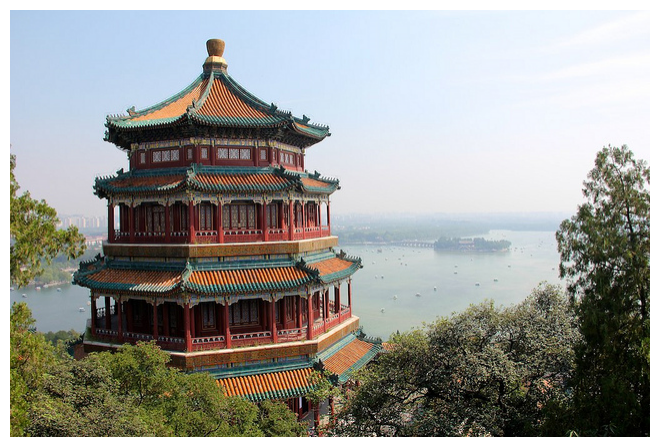

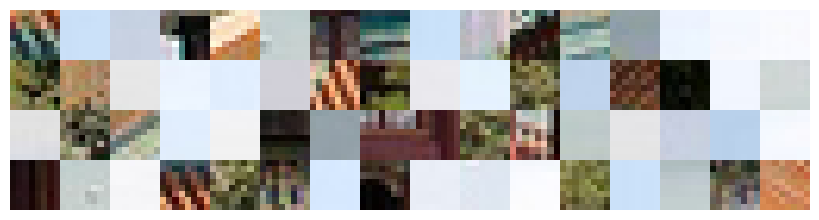

In [2]:
I = sklearn.datasets.load_sample_image('china.jpg')
X = sklearn.feature_extraction.image.extract_patches_2d(
    I, (8, 8), max_patches=10000, random_state=0)
utils.showimage(I)
utils.showpatches(X)

As a starting point, the patches we have extracted are flattened to appear as abstract input vectors of $8 \times 8 \times 3 = 192$ dimensions. The input data is then centered and standardized.

In [3]:
X = X.reshape(len(X), -1)
X = X - X.mean(axis=0)
X = X / X.std()

## Whitening (10 P)

A precondition for applying the ICA procedure is that the input data has variance $1$ under any projection. This can be achieved by whitening, which is a transformation $\mathcal{W}:\mathbb{R}^d \to \mathbb{R}^d$ with $z = \mathcal{W}(x)$ such that $\mathrm{E}[zz^\top] = I$.

A simple procedure for whitening a collection of data points $x_1,\dots,x_N$ (assumed to be centered) first computes the PCA components $u_1,\dots,u_d$ of the data and then applies the following three consecutive steps:

 1. project the data on the PCA components i.e. $p_{n,i} = x_n^\top u_i$.
 2. divide the projected data by the standard deviation in PCA space, i.e. $\tilde{p}_{n,i} = p_{n,i} / \text{std}(p_{:,i})$
 3. backproject to the input space $z_n = \sum_i \tilde{p}_{n,i} u_i$.

**Task:**

 * **Implement this whitening procedure, in particular, write a function that receives the input data matrix and returns the matrix containing all whitened data points.**
 
For efficiency, your whitening procedure should be implemented in matrix form.

In [4]:
import numpy.linalg


def whitening(X):
    X_new = X.T
    U = numpy.linalg.eigh(X_new @ X_new.T)[1]
    P = X_new.T @ U
    P = P/P.std(axis=0)

    Z = P @ U.T

    return Z


Z = whitening(X)

The code below verifies graphically that whitening has removed correlations between the different input dimensions:

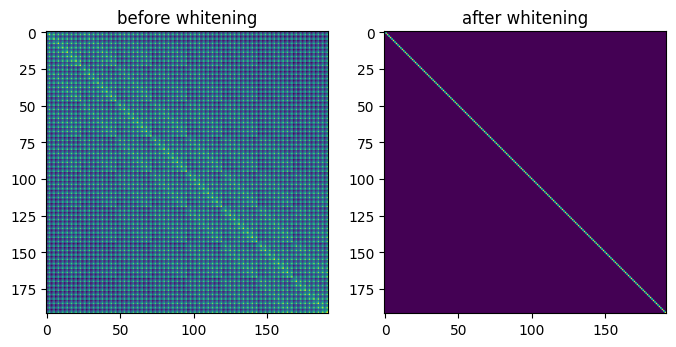

In [5]:
f = plt.figure(figsize=(8, 4))
p = f.add_subplot(1, 2, 1)
p.set_title('before whitening')
p.imshow(numpy.dot(X.T, X)/len(X))
p = f.add_subplot(1, 2, 2)
p.set_title('after whitening')
p.imshow(numpy.dot(Z.T, Z)/len(Z))
plt.show()

Finally, to get visual picture of what will enter into our ICA algorithm, the whitened data can be visualized in the same way as the original input data.

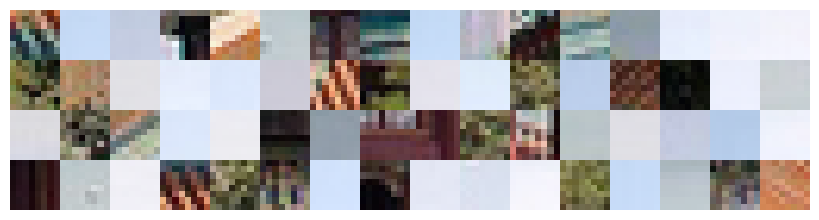

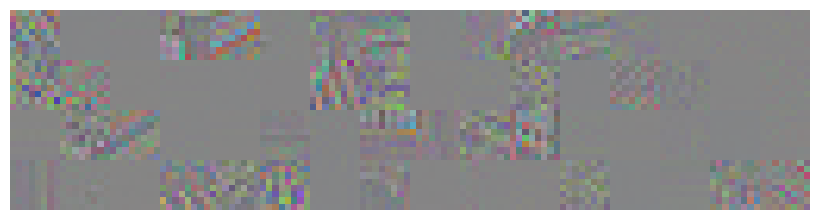

In [6]:
utils.showpatches(X)
utils.showpatches(Z)

We observe that all high constrasts and spatial correlations have been removed after whitening. Remaining patterns include high-frequency textures and oriented edges of different colors.

## Implementing ICA (20 P)


We now would like to learn $h=64$ independent components of the distribution of whitened image patches. For this, we adopt a procedure similar to the FastICA procedure described in the paper above. In particular, we start with random weights $w_1,\dots,w_h \in \mathbb{R}^d$ and iterate multiple times the sequence of operations:

 1. $\forall_{i=1}^d~w_i = \mathbb{E}[x \cdot g(w_i^\top x)] - w_i \cdot \mathbb{E}[ g'(w_i^\top x)]$
 2. $w_1,\dots,w_h=\text{decorrelate}\{w_1,\dots,w_h\}$

where $\mathbb{E}[\cdot]$ denotes the expectation with the data distribution.

The first step increases non-Gaussianity of the projected data. Here, we will make use of the nonquadratic function $G(x) = \frac1a \log \cosh (a x)$ with $a=1.5$. This function admits as a derivative the function $g(x) = \tanh(a x)$, and as a double derivative the function $g'(x) = a \cdot (1-\tanh^2(a x))$.

The second step enforces that the learned projections are decorrelated, i.e.\ $w_i^\top w_j = 1_{i=j}$. It will be implemented by calling in an appropriate manner the whitening procedure which we have already implemented to decorrelate the different input dimensions.

This procedure minimizes the non-Gaussianity of the projected data as measured by the objective:

$$
J(w) = \sum_{i=1}^h (\mathbb{E}[G(w_i^\top x)] - \mathbb{E}[G(\varepsilon)])^2 \qquad \text{where} \quad \varepsilon \sim \mathcal{N}(0,1).
$$


**Task:**

* **Implement the ICA procedure described above, run it for 200 iterations, and print the value of the objective function every 25 iterations.**

In order to keep the learning procedure computationally affordable, the code must be parallelized, in particular, make use of numpy matrix multiplications instead of loops whenever it is possible.

In [14]:
def G(x):
    return 1 / 1.5 * numpy.log(numpy.cosh(1.5 * x))


def g(x):
    return numpy.tanh(1.5 * x)


def dg(x):
    return 1.5 * (1 - numpy.tanh(1.5 * x) ** 2)


def fastICA(Z, h):
    N, d = Z.shape
    R = numpy.random.normal(0, 1, [N, h])
    W = whitening(numpy.random.normal(0, 1, [h, d]).T).T / d**0.5

    for i in range(1, 201):
        P = Z @ W.T
        W = (g(P).T @ Z) / N - W * dg(P).mean(axis=0)[:, numpy.newaxis]
        W = whitening(W.T).T / d**0.5
        if (i % 25) == 0:
            print(((G(P).mean(axis=0) - G(R).mean(axis=0)) ** 2).sum())


W = fastICA(Z, 64)

1.4411497104837054
1.7733526616764093
1.919572806589692
1.9930117989832707
2.0369418251653295
2.064721756502041
2.087902731269207
2.0957192066701023


Because the learned ICA components are in a space of same dimensions as the input data, they can also be visualized as image patches.

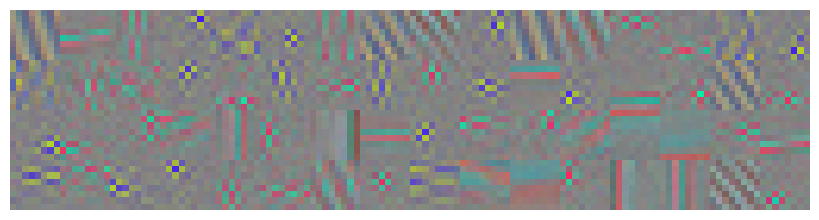

In [12]:
utils.showpatches(W)

We observe that an interesting decomposition appears, composed of frequency filters, edges filters and localized texture filters. The decomposition further aligns on specific directions of the RGB space, specifically yellow/blue and red/cyan.

To verify that strongly non-Gaussian components have been learned, we build a histogram of projections on the various ICA components and compare it to histograms for random projections.

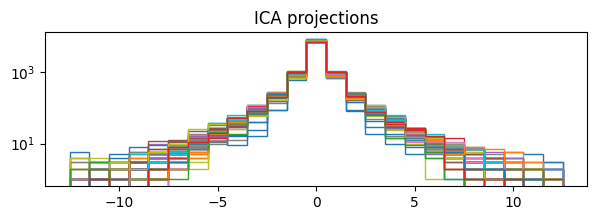

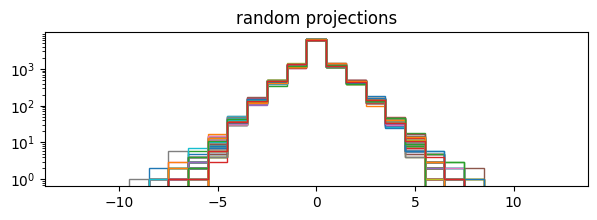

In [13]:
import numpy
plt.figure(figsize=(7, 2))
for i in range(64):
    plt.hist(numpy.dot(Z, W[i]), bins=numpy.linspace(-12.5,
             12.5, 26), histtype='step', log=True)
plt.title('ICA projections')
plt.show()

plt.figure(figsize=(7, 2))
for i in range(64):
    R = numpy.random.mtrand.RandomState(i).normal(0, 1, Z.shape[1])
    plt.hist(numpy.dot(Z, R/(R**2).sum()**.5),
             bins=numpy.linspace(-12.5, 12.5, 26), histtype='step', log=True)
plt.title('random projections')
plt.show()

We observe that the ICA projections have much heavier tails. This is a typical characteristic of independent components of a data distribution.